### Prudhviraj Tirumanisetti
EE 258 ID:011489881

In [1]:
%matplotlib inline
import csv
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
## Reading train and test files

In [3]:
all_train_df = pd.read_csv("train.csv")
all_test_df = pd.read_csv("test.csv")

In [4]:
## feature names from the dataset

In [5]:
print (all_test_df.columns)

Index([u'PassengerId', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')


In [6]:
## extract labels and drop irrelevant features

In [7]:
all_train_df = all_train_df.drop(['PassengerId','Name','Cabin','Ticket'],axis=1)
#all_test_df = all_test_df.drop(['PassengerId','Name','Cabin','Ticket'])

In [8]:
## drop missing values

In [9]:
all_train_df = all_train_df.dropna()

In [10]:
labels = pd.DataFrame(all_train_df['Survived'])
all_train_df = all_train_df.drop(['Survived'],axis=1)

In [11]:
## final shape of preprocessed training set

In [12]:
print (all_train_df.shape)

(712, 7)


In [13]:
## encoding nominal features

In [14]:
sex_trans = { 'male':0,
       'female':1
      }

embarked_trans = { 'S':0,
                  'C':1,
                  'Q':2
                 }



In [15]:
all_train_df['Sex'] = all_train_df['Sex'].apply(lambda x : sex_trans[x])
all_train_df['Embarked'] = all_train_df['Embarked'].apply(lambda x : embarked_trans[x])

In [16]:
## standardization of features using StandardScalar

In [17]:
all_train_df = pd.DataFrame(StandardScaler().fit_transform(all_train_df.values),columns=['Pclass', 'Sex',
                                                                                         'Age',  'SibSp',  'Parch'
                                                                                         ,'Fare',  'Embarked'])

In [18]:
## Feature Boxplot

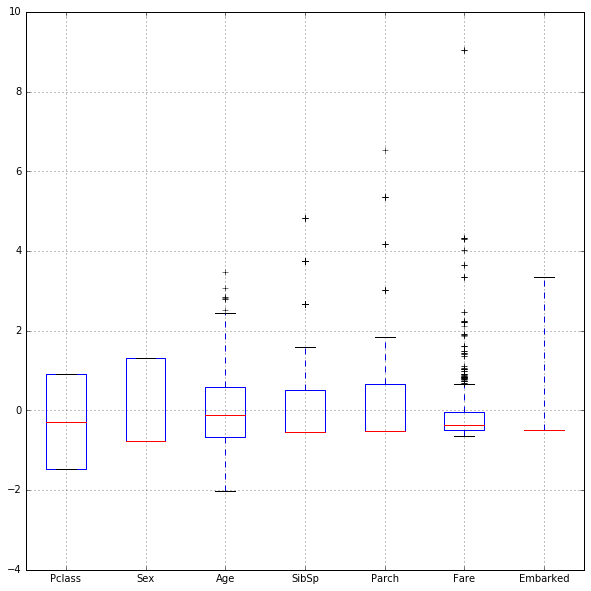

In [19]:
plt.figure(figsize=(10,10))
all_train_df.boxplot(return_type='axes')
plt.show()

In [20]:
## Summary description of our features

In [21]:
all_train_df.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,7.120000e+02,7.120000e+02,7.120000e+02,7.120000e+02,7.120000e+02,7.120000e+02,7.120000e+02
mean,-1.587369e-16,-5.083325e-17,2.584933e-16,4.216353e-16,-1.372186e-17,-6.221615e-17,-1.640386e-16
std,1.000703e+00,1.000703e+00,1.000703e+00,1.000703e+00,1.000703e+00,1.000703e+00,1.000703e+00
min,-1.482983e+00,-7.561375e-01,-2.017717e+00,-5.527137e-01,-5.067874e-01,-6.534272e-01,-5.012257e-01
25%,-1.482983e+00,-7.561375e-01,-6.657639e-01,-5.527137e-01,-5.067874e-01,-5.012575e-01,-5.012257e-01
50%,-2.871914e-01,-7.561375e-01,-1.133826e-01,-5.527137e-01,-5.067874e-01,-3.576726e-01,-5.012257e-01
75%,9.085997e-01,1.322511e+00,5.770939e-01,5.225108e-01,6.647471e-01,-2.962586e-02,-5.012257e-01
max,9.085997e-01,1.322511e+00,3.477095e+00,4.823409e+00,6.522419e+00,9.031168e+00,3.336115e+00


In [22]:
## label distribution

In [23]:
label_distribution = labels.groupby('Survived')
label_distribution['Survived'].count()

Survived
0    424
1    288
Name: Survived, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x108671c10>], dtype=object)

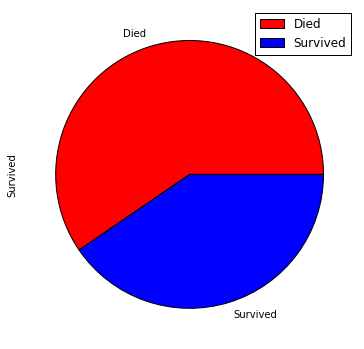

In [24]:
pie = pd.DataFrame(label_distribution['Survived'].count())
pie.plot(kind='pie',figsize=(6,6),subplots=True,labels=['Died','Survived'],colors=['r','b'])

In [25]:
def folds_to_split(data,targets,train,test):
    data_tr = pd.DataFrame(data).iloc[train]
    data_te = pd.DataFrame(data).iloc[test]
    labels_tr = pd.DataFrame(targets).iloc[train]
    labels_te = pd.DataFrame(targets).iloc[test]
    return [data_tr, data_te, labels_tr, labels_te]

In [26]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB, GaussianNB,MultinomialNB
from sklearn import linear_model

from sklearn.neighbors import KNeighborsClassifier


import itertools
lb = pd.DataFrame(labels['Survived'].values)
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


def findsubsets(S,m):
    return set(itertools.combinations(S, m))

bestaccuracy=0
model_accuracy = pd.DataFrame()
mcount=0

models = {"KNN":KNeighborsClassifier(20),"BernoulliNB":BernoulliNB(),"GaussianNB":GaussianNB(),"Logistic":linear_model.LogisticRegression(C=1e5)}
for name,model in models.items():
    print ("\nThe learning method is ",name)
    print("\n")
    bestaccuracy = 0
    for i in range(1,8):
        for attr in findsubsets(features,i):
            tr_df = all_train_df[list(attr)]
            stratified = StratifiedKFold(lb[0], n_folds=10,random_state=20160121, shuffle=True)
            print ("The selected features are ",(list(attr)))
            results_df = pd.DataFrame()
            foldnum=0
            for train,test in stratified:
                [data_tr,data_va,labels_tr,labels_va] = folds_to_split(tr_df,labels,train,test)

                model.fit(data_tr, labels_tr.values.ravel())
                results_df.loc[foldnum,'accuracy'] = model.score(data_va.values,labels_va.values.ravel())
                foldnum=foldnum+1
            print (results_df.mean())
            if (bestaccuracy < (results_df['accuracy'].mean())):
                bestaccuracy = results_df['accuracy'].mean()
                bestmodel = name
                bestfeatures = attr
    model_accuracy.loc[mcount,'accuracy'] = bestaccuracy
    model_accuracy.loc[mcount,'model'] = bestmodel
    model_accuracy.loc[mcount,'features'] = ' '.join(bestfeatures)
    mcount=mcount+1              

('\nThe learning method is ', 'KNN')


('The selected features are ', ['Sex'])
accuracy    0.779384
dtype: float64
('The selected features are ', ['SibSp'])
accuracy    0.595509
dtype: float64
('The selected features are ', ['Fare'])
accuracy    0.665822
dtype: float64
('The selected features are ', ['Age'])
accuracy    0.609535
dtype: float64
('The selected features are ', ['Embarked'])
accuracy    0.510682
dtype: float64
('The selected features are ', ['Parch'])
accuracy    0.469268
dtype: float64
('The selected features are ', ['Pclass'])
accuracy    0.606737
dtype: float64
('The selected features are ', ['Sex', 'Age'])
accuracy    0.784958
dtype: float64
('The selected features are ', ['Pclass', 'Age'])
accuracy    0.686849
dtype: float64
('The selected features are ', ['Parch', 'Fare'])
accuracy    0.671398
dtype: float64
('The selected features are ', ['Age', 'Embarked'])
accuracy    0.630702
dtype: float64
('The selected features are ', ['Sex', 'Fare'])
accuracy    0.756925
dtyp

In [27]:
print ("Following are the best results for each model\n",model_accuracy)

('Following are the best results for each model\n',    accuracy        model                             features
0  0.816146          KNN  Pclass Sex Age SibSp Parch Embarked
1  0.779384  BernoulliNB                                  Sex
2  0.804599     Logistic        Pclass Sex Age SibSp Embarked
3  0.786368   GaussianNB              Sex SibSp Fare Embarked)


In [28]:
ids = all_test_df['PassengerId']
all_test_df = all_test_df.drop(['PassengerId','Name','Cabin','Ticket'],axis=1)

In [29]:
all_test_df['Sex'] = all_test_df['Sex'].apply(lambda x : sex_trans[x])
all_test_df['Embarked'] = all_test_df['Embarked'].apply(lambda x : embarked_trans[x])

In [30]:
pd.options.display.max_rows = 1000
age_mean = all_test_df['Age'].mean()
all_test_df.loc[all_test_df['Age'].isnull(),'Age']=age_mean
fare_mean = all_test_df.groupby('Pclass')['Fare'].mean()
all_test_df.loc[all_test_df['Fare'].isnull(),'Fare']=fare_mean[3]

In [31]:
all_test_df = pd.DataFrame(StandardScaler().fit_transform(all_test_df.values),columns=['Pclass', 'Sex',
                                                                                         'Age',  'SibSp',  'Parch'
                                                                                         ,'Fare',  'Embarked'])



In [32]:
model = KNeighborsClassifier(20)
model.fit(tr_df[['Pclass','Sex','Age','SibSp','Parch','Embarked']],lb[0])
output = model.predict(all_test_df[['Pclass','Sex','Age','SibSp','Parch','Embarked']].values)

In [33]:
predictions_file = open("knn.csv", "w")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print ('Done.')

Done.


In [34]:
model = BernoulliNB()
model.fit(tr_df[['Sex']],lb[0])
output = model.predict(all_test_df[['Sex']].values)

In [35]:
predictions_file = open("bernoulli.csv", "w")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print ('Done.')

Done.


In [36]:
model = GaussianNB()
model.fit(tr_df[['Sex','SibSp', 'Fare', 'Embarked']],lb[0])
output = model.predict(all_test_df[['Sex','SibSp', 'Fare', 'Embarked']].values)

In [37]:
predictions_file = open("gaussian.csv", "w")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print ('Done.')

Done.


In [38]:
model = linear_model.LogisticRegression(C=1e5)
model.fit(tr_df[['Pclass','Sex','Age','SibSp','Embarked']],lb[0])
output = model.predict(all_test_df[['Pclass','Sex','Age','SibSp','Embarked']].values)

In [39]:
predictions_file = open("logistic.csv", "w")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print ('Done.')

Done.
